In [1]:
import os
from google.colab import drive

from PIL import Image
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point, MultiPoint
from shapely.ops import nearest_points
import cv2

# Configuración de google drive

In [2]:
# Montar google drive
drive.mount('/content/drive')

# Cambiar de directorio raiz
ROOT_DIR = '/content/drive/MyDrive/mole-mapper'
os.chdir(ROOT_DIR)

Mounted at /content/drive


# Predicción con modelo entrenado con YOLO

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [4]:
from ultralytics import YOLO

#Cargamos el mejor modelo para segmentación
model = YOLO('/content/drive/MyDrive/mole-mapper/runs/segment/train/weights/best.pt')

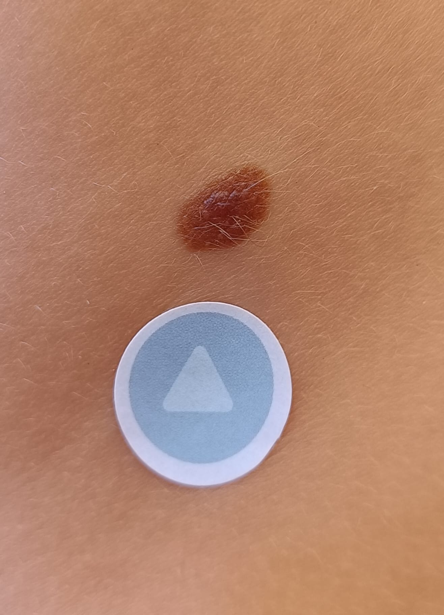

In [5]:
#Imagen para realizar la predicción
source='/content/drive/MyDrive/mole-mapper/data/processed/dataset-mole-ref/test/IMG-20240822-WA0005.jpg'
#IMG_20240622_193522.jpg

img = Image.open(source)
img = img.resize((444, 615))
display(img)

In [11]:
results = model.predict(source=source, save=True) #save=True para guardar el resultado en runs/segment/predict


image 1/1 /content/drive/MyDrive/mole-mapper/data/processed/dataset-mole-ref/test/IMG-20240822-WA0005.jpg: 640x544 1 mole, 1 star, 96.6ms
Speed: 12.8ms preprocess, 96.6ms inference, 857.7ms postprocess per image at shape (1, 3, 640, 544)
Results saved to runs/segment/predict4


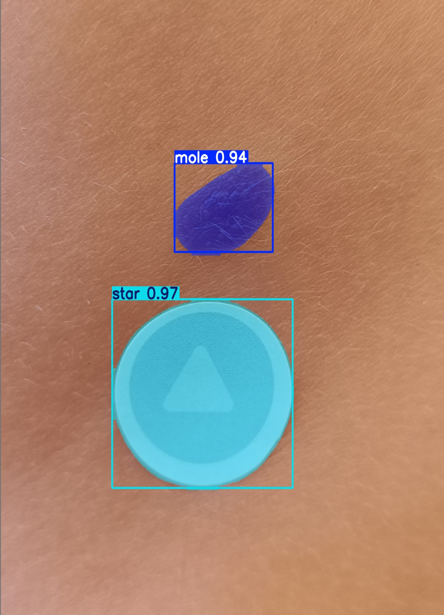

In [12]:
#Imagen de la predicción
source_pred='/content/drive/MyDrive/mole-mapper/runs/segment/predict3/IMG-20240822-WA0005.jpg'

img = Image.open(source_pred)
img = img.resize((444, 615))
display(img)

# Calculo del área real y ejes del lunar

Funciones creadas para calcular el área en la imagen, la longitud de los ejes en la imagen y para representar en una imagen los ejes calculados.

In [13]:
def calculate_area(polygon):
    ''' Calcular el área de un polígono usando la fórmula de Shoelace '''
    x = polygon[:, 0]
    y = polygon[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

In [14]:
def calculate_longest_line(polygon):
    max_distance = 0
    longest_line = None
    for i in range(len(polygon)):
        for j in range(i + 1, len(polygon)):
            p1 = polygon[i]
            p2 = polygon[j]
            distance = np.linalg.norm(np.array(p1) - np.array(p2))
            if distance > max_distance:
                max_distance = distance
                longest_line = (p1, p2)
    return np.array(longest_line), np.array(max_distance)

In [15]:
def calculate_perpendicular_intersections(longest_line, polygon):
    # Calcular el punto medio de la línea más larga
    p1, p2 = longest_line
    midpoint = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

    # Calcular la pendiente de la línea más larga
    if (p2[0] - p1[0]) != 0:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
    else:
        slope = float('inf')

    # La pendiente de la línea perpendicular
    if slope != 0 and slope != float('inf'):
        perpendicular_slope = -1 / slope
        perp_line = LineString([(midpoint[0] - 1000, midpoint[1] - 1000 * perpendicular_slope),
                                (midpoint[0] + 1000, midpoint[1] + 1000 * perpendicular_slope)])
    else:
        perp_line = LineString([(midpoint[0], midpoint[1] - 1000),
                                (midpoint[0], midpoint[1] + 1000)])

    # Encontrar la intersección de la línea perpendicular con el contorno del polígono
    poly = Polygon(polygon)
    intersection = perp_line.intersection(poly.boundary)

    # Manejar diferentes tipos de resultados de intersección
    intersection_points = []
    if isinstance(intersection, Point):
        intersection_points = [intersection]
    elif isinstance(intersection, MultiPoint):
        intersection_points = [point for point in intersection.geoms]
    elif isinstance(intersection, LineString):
        intersection_points = [Point(coords) for coords in intersection.coords]

    if len(intersection_points) == 0:
        raise ValueError("No se encontraron intersecciones entre la línea perpendicular y el contorno del lunar.")

    # Encontrar la distancia desde el punto medio a la intersección
    distances = [np.linalg.norm(np.array(midpoint) - np.array([point.x, point.y])) for point in intersection_points]
    max_distance = max(distances)

    return midpoint, intersection_points, max_distance

In [22]:
def plot_mole_axes(image_path, longest_line, midpoint, intersection, longest_line_cm, perp_line_cm):
    # Cargar la imagen
    img = plt.imread(image_path)

    # Configurar la figura
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Dibujar la línea longitudinal más larga
    p1, p2 = longest_line
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue', linewidth=2, label=f"Major axis: {longest_line_cm:.2f} cm")

    # Dibujar la línea perpendicular desde el punto medio
    for i, point in enumerate(intersection):
      if i == 0:  # Solo añadir la etiqueta en la primera iteración
          plt.plot([midpoint[0], point.x], [midpoint[1], point.y], color='red', linewidth=2, label=f"Minor axis: {perp_line_cm:.2f} cm")
      else:
          plt.plot([midpoint[0], point.x], [midpoint[1], point.y], color='red', linewidth=2)

    #plt.scatter(*midpoint, color='yellow', label='Punto Medio')
    #plt.scatter(*zip(*[(point.x, point.y) for point in intersection]), color='purple', label='Intersección')

    plt.legend()
    plt.axis('off')
    plt.show()

Diámetro del circulo real de referencia: 1.80 cm
Área del circulo de referencia: 2.54 cm²

Área del lunar: 0.60 cm²
Eje mayor: 1.0841535522299106 cm
Diámetro del lunar real, asumiendo que es circular: 0.87 cm
Eje menor: 0.3705722423744495 cm


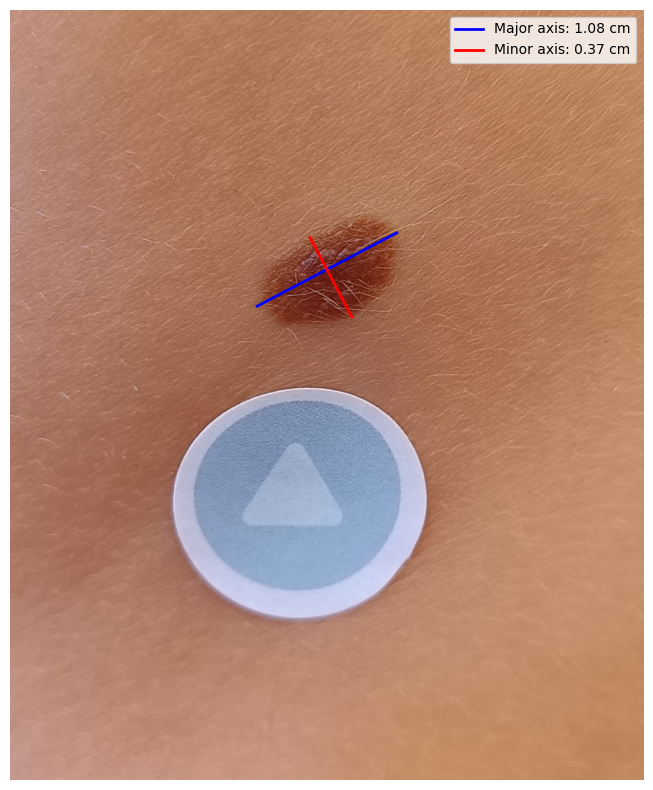

In [23]:
# Diámetro del círculo de referencia en cm
reference_diameter_cm = 1.8
reference_radius_cm = reference_diameter_cm / 2
reference_area_cm2 = np.pi * (reference_radius_cm ** 2)

# Asumimos que la segmentación retorna las máscaras de los objetos detectados
reference_polygon = None
lunar_polygon = None

for i, mask in enumerate(results[0].masks.xy):
    class_id = results[0].boxes.cls[i]
    if class_id == 1:  # Clase 1 es "Referencia"
        reference_polygon = mask
        reference_bbox = results[0].boxes.xywh[i]  # Asumiendo que xywh son las coordenadas del bounding box
    elif class_id == 0:  # Clase 0 es "Lunar"
        lunar_polygon = mask

if reference_polygon is not None and lunar_polygon is not None:
    # Calcular el área del círculo de referencia en la imagen
    reference_area = calculate_area(reference_polygon)

    # Calcular el área del lunar en la imagen
    lunar_area = calculate_area(lunar_polygon)

    # Calcular el área del lunar en cm²
    lunar_area_cm2 = (lunar_area / reference_area) * reference_area_cm2

    # Calcular el diámetro del lunar en cm (asumiendo que es circular para simplificar)
    lunar_diameter_cm = 2 * np.sqrt(lunar_area_cm2 / np.pi)

    # Encontrar la línea longitudinal más larga del lunar
    mole_longline, mole_longline_distance = calculate_longest_line(lunar_polygon)

    # Encontrar la línea longitudinal más larga del circulo de referencia
    ref_longline, ref_longline_distance = calculate_longest_line(reference_polygon)

    # Calcular linea longitudinal en cm²
    longest_line_cm = (mole_longline_distance * reference_diameter_cm) / ref_longline_distance

    print(f"Diámetro del circulo real de referencia: {reference_diameter_cm:.2f} cm")
    print(f"Área del circulo de referencia: {reference_area_cm2:.2f} cm²\n")

    print(f"Área del lunar: {lunar_area_cm2:.2f} cm²")
    print(f"Eje mayor: {longest_line_cm} cm")
    print(f"Diámetro del lunar real, asumiendo que es circular: {lunar_diameter_cm:.2f} cm")

    # Calcular la línea perpendicular
    try:
        midpoint, intersection_points, mole_perpline_distance = calculate_perpendicular_intersections(mole_longline, lunar_polygon)

        # Calcular linea longitudinal en cm²
        perp_line_cm = (mole_perpline_distance * reference_diameter_cm) / ref_longline_distance

        print(f"Eje menor: {perp_line_cm} cm")

        plot_mole_axes(source, mole_longline, midpoint, intersection_points, longest_line_cm, perp_line_cm)

    except ValueError as e:
        print(str(e))

    # Llamar a la función de visualización solo si se encontró el lunar
    #plot_longest_line(source, mole_longline)

else:
    print("No se detectaron tanto el círculo de referencia como el lunar.")


# Introducir una imagen con un calibre y la medición. Para demostrar que la medición es precisa

# Alternativa para visualizar el lunar con sus ejes utilizando cv2

In [ ]:
# Función para asignar colores únicos a cada clase
def get_color(label, num_classes):
    colors = [
        (255, 0, 0),   # Red
        (0, 255, 0),   # Green
        (0, 0, 255),   # Blue
        (255, 255, 0), # Cyan
        (255, 0, 255), # Magenta
        (0, 255, 255), # Yellow
    ]
    return colors[label % len(colors)]

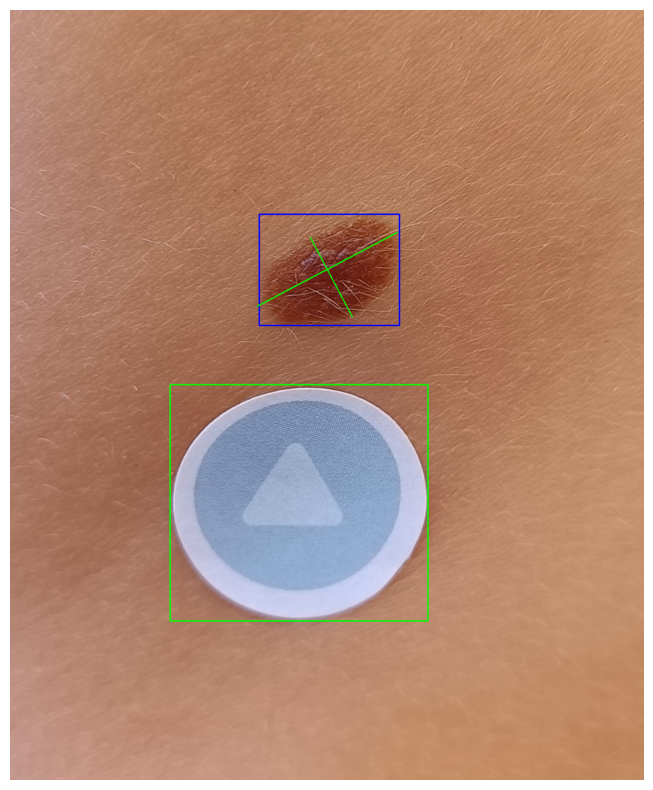

In [ ]:
image = cv2.imread(source)
if image is None:
  print(f"Error: Could not load image from {source}")

# Dibujar la bounding box de los resultados
for result in results:
  boxes = result.boxes.xyxy  # Obtener las coordenadas de las bounding boxes
  classes = result.boxes.cls  # Obtener las clases
  num_classes = len(set(classes))  # Número de clases únicas
  for box, cls in zip(boxes, classes):
    x1, y1, x2, y2 = map(int, box[:4])
    color = get_color(int(cls), num_classes)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)  # Dibujar la bounding box
    #cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Dibuja el eje mayor
pt1 = tuple(mole_longline[0].astype(int))
pt2 = tuple(mole_longline[1].astype(int))
cv2.line(image, pt1, pt2, (0, 255, 0), 2)

# Dibuja el punto medio
#midpoint_int = tuple(map(int, midpoint))
#cv2.circle(image, midpoint_int, 5, (0, 0, 255), -1)

# Dibuja los puntos de intersección
#for point in intersection_points:
#    pt = tuple(map(int, [point.x, point.y]))
#    cv2.circle(image, pt, 5, (255, 255, 0), -1)

# Dibuja el eje menor
pt1 = tuple(map(int,[intersection_points[0].x, intersection_points[0].y]))
pt2 = tuple(map(int,[intersection_points[1].x, intersection_points[1].y]))
cv2.line(image, pt1, pt2, (0, 255, 0), 2)

# Convierte imagen BGR a RGB para trazar
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

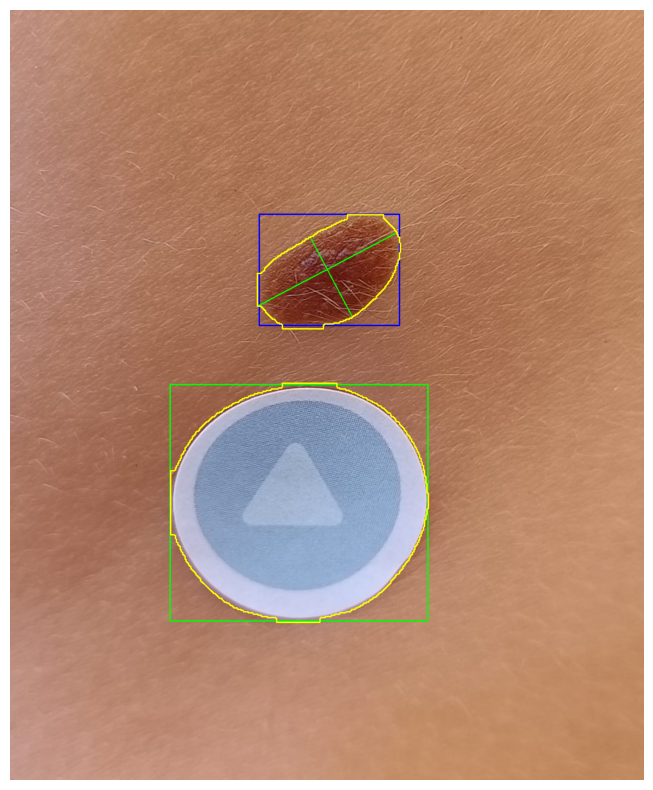

In [ ]:
for result in results:
  masks=result.masks.xy
  for poly in masks:
    cv2.polylines(image, [np.array(poly, dtype=np.int32)], isClosed=True, color=(0, 255, 255), thickness=2)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
